# Dask is a graph execution engine

Dask allows you to construct a prescription for the calculation you want to carry out.

In [1]:
from dask import delayed
from __future__ import print_function

@delayed
def inc(x):
    return x + 1

@delayed
def add(x, y):
    return x + y


Here we have used the delayed annotation to show that we want these functions to operate lazily - to save the set of inputs and execute only on demand. dask.delayed is also a function which can do this, without the annotation, leaving the original function unchanged, e.g.,

```delayed_inc = delayed(inc)```

In [2]:
x = inc(15)
y = inc(30)
total = add(x, y)
# incx, incy and total are all delayed objects. 
# They contain a prescription of how to execute

We can visualize the chain of calculations that the object total corresponds to as follows; the circles are functions, rectangles are data/results.

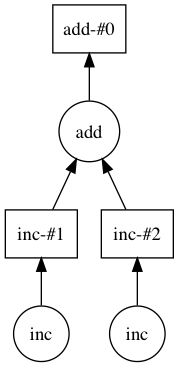

In [3]:
total.visualize()

But so far, no functions have actually been executed. To run the "graph" in the visualization, and actually get a result, do:

In [4]:
# execute all tasks
total.compute()

47

# Example 1
Consider reading two CSV files with pd.read_csv and then measuring their total length. We will consider how you would do this with ordinary Python code, then build a graph for this process using delayed, and finally execute this graph using Dask, for a handy speed-up factor of more than two (there are only three inputs to parallelize over).

In [5]:
import pandas as pd
from glob import glob

In [6]:
filenames = glob("../toy-data/*.csv")

In [7]:
filenames

['../toy-data/500_Cities__Local_Data_for_Better_Health.csv',
 '../toy-data/Demographic_Statistics_By_Zip_Code.csv']

In [8]:
%%time

# normal, sequential code
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])

na = len(a)
nb = len(b)

total = sum([na, nb])
print(total)

810339
CPU times: user 3.19 s, sys: 330 ms, total: 3.52 s
Wall time: 3.53 s


Recreate this graph again using the delayed function on the original Python code. The three functions you want to delay are pd.read_csv, len and sum..

In [9]:
from dask.multiprocessing import get
delayed_read_csv = delayed(pd.read_csv)
a = delayed_read_csv(filenames[0])
b = delayed_read_csv(filenames[1])

delayed_len = delayed(len)
na = delayed_len(a)
nb = delayed_len(b)

delayed_sum = delayed(sum)
total = delayed_sum([na, nb])

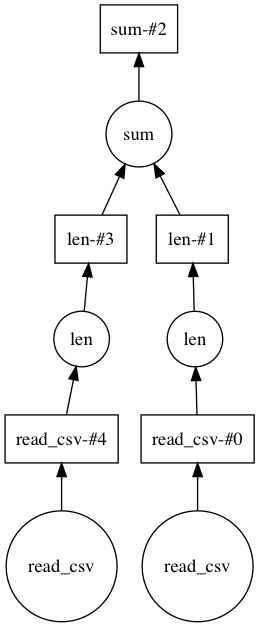

In [10]:
total.visualize()

In [11]:
# execute with multiprocessing scheduler
%time total.compute(get=get)

CPU times: user 32.8 ms, sys: 33.7 ms, total: 66.5 ms
Wall time: 3.64 s


810339

In [12]:
# concise version
csvs = [delayed(pd.read_csv)(fn) for fn in filenames]
lens = [delayed(len)(csv) for csv in csvs]
total = delayed(sum)(lens)
%time total.compute(get=get)

CPU times: user 23.6 ms, sys: 33.8 ms, total: 57.4 ms
Wall time: 3.5 s


810339

# Example 2: Simple word count
How would you count the number of workds in a file?

- The simplest approach would be to load all the data into memory, split on whitespace and count the number of results. Here we use a regular expression to split words.

In [13]:
import re
splitter = re.compile('\w+')
with open('../requirements.txt', 'r') as f:
    data = f.read()
result = len(splitter.findall(data))
        
result

795

The trouble with this approach is that it does not scale - if the file is very large, it, and the generated list of words, might fill up memory. We can easily avoid that, because we only need a simple sum, and each line is totally independent of the others. Now we evaluate each piece of data and immediately free up the space again, so we could perform this on arbitrarily-large files. Note that there is often a trade-off between time-efficiency and memory footprint: the following uses very little memory, but may be slower for files that do not fill a large faction of memory. In general, one would like chunks small enough not to stress memory, but big enough for efficient use of the CPU.

In [14]:
result = 0
with open('../requirements.txt', 'r') as f:
    for line in f:
        result += len(splitter.findall(line))
result

795

# Example 3: Background execution

There are many tasks that take a while to complete, but don't actually require much of the CPU, for example anything that requires communication over a network, or input from a user. In typical sequential programming, execution would need to halt while the process completes, and then continue execution. That would be dreadful for a user experience (imagine the slow progress bar that locks up the application and cannot be canceled), and wasteful of time (the CPU could have been doing useful work in the meantime.
For example, we can launch processes and get their output as follows:

```python
import subprocess
    p = subprocess.Popen(command, stdout=subprocess.PIPE)
    p.returncode
```

The task runs in a separate process, and the return-code will remain None until it completes, when it will change to 0. To get the result back, we need ```out = p.communicate()[0]``` (which would block if the process was not complete).


Similarly, we can launch Python processes and threads in the background. Some methods allow mapping over multiple inputs and gathering the results, more on that later. The thread starts and the cell completes immediately, but the data associated with the download only appears in the queue object some time later.


In [15]:
import threading
import queue
import urllib

In [16]:
def get_webdata(url, q):
    u = urllib.urlopen(url)
    #u = urllib.urlretrieve(url)
    q.put(u.read)

In [17]:
q = queue.Queue()
t = threading.Thread(target=get_webdata, args=('http://www.google.com', q))
t.start()

In [18]:
# fetch result back into this thread. If the worker thread is not done, this would wait.
q.get()

<bound method _fileobject.read of <socket._fileobject object at 0x11f2a3150>>

Any Dask object, such as total, above, as an attribute which describes the calculations necessary to produce that result. Indeed, this is exactly the graph that we have been talking about, which can be visualized. We see that it is a simple dictionary, the keys are unique task identifiers, and the values are the functions and inputs for calculation.
delayed is a handy mechanism for creating the Dask graph, but the adventerous may wish to play with the full fexibility afforded by building the graph dictionaries directly. Detailed information can be found [here](http://dask.pydata.org/en/latest/graphs.html).


In [19]:
total.dask

In [20]:
dict(total.dask)

{'len-a482afb3-6acf-4e72-ad29-9ba6f77ed796': (<function len>,
  'read_csv-0b762e8d-8a8d-4c9b-b3ea-b952489c12e3'),
 'len-b39e0e62-e599-4261-8769-7d1b00dbb523': (<function len>,
  'read_csv-da8fee46-6ec2-4d45-ac77-6ac2cb6f7e07'),
 'read_csv-0b762e8d-8a8d-4c9b-b3ea-b952489c12e3': (<function pandas.io.parsers.read_csv>,
  '../toy-data/500_Cities__Local_Data_for_Better_Health.csv'),
 'read_csv-da8fee46-6ec2-4d45-ac77-6ac2cb6f7e07': (<function pandas.io.parsers.read_csv>,
  '../toy-data/Demographic_Statistics_By_Zip_Code.csv'),
 'sum-ab0ad680-b06c-4152-842f-6597556f2010': (<function sum>,
  ['len-a482afb3-6acf-4e72-ad29-9ba6f77ed796',
   'len-b39e0e62-e599-4261-8769-7d1b00dbb523'])}